# License

Copyright 2018 Hamaad Musharaf Shah

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Using Bidirectional Generative Adversarial Networks to estimate Value-at-Risk for Market Risk Management
## Author: Hamaad Shah

---

We will explore the use of Bidirectional Generative Adversarial Networks (BiGAN) for market risk management: Estimation of portfolio risk measures such as Value-at-Risk (VaR). Generative Adversarial Networks (GAN) allow us to implicitly maximize the likelihood of complex distributions thereby allowing us to generate samples from such distributions - the key point here is the implicit maximum likelihood estimation principle whereby we do not specify what this complex distribution is parameterized as. Dealing with high dimensional data potentially coming from a complex distribution is a key aspect to market risk management among many other financial services use cases. GAN, specifically BiGAN for the purpose of this paper, will allow us to deal with potentially complex financial services data such that we do not have to explicitly specify a distribution such as a multidimensional Gaussian distribution.

## Market Risk Management: Value-at-Risk (VaR)

---

Let us begin by fetching a data set of 5 stocks from Yahoo. The stocks are Apple, Google, Microsoft, Intel and Box. We use a daily frequency for our data for the year 2016. We use the stock's daily closing prices to compute the continuously compounded returns: $\log\left(\frac{V_{t+1}}{V_{t}}\right) = \log(V_{t+1}) - \log(V_{t})$.

```r
# Set scientific notation penalty to high for better printing.
options(scipen = 999)

# Load required libraries.
library(ggplot2)
library(quantmod)
library(MASS)
library(scales)
library(reshape2)

# Let's take a year's worth of data.
start <- as.Date("2016-01-01")
end <- as.Date("2016-12-31")

# Let's get Apple, Google, Microsoft, Intel and Box data from Yahoo.
getSymbols(Symbols = "AAPL;GOOG;MSFT;INTC;BOX", 
           src = "yahoo", 
           from = start, 
           to = end)

# Create daily returns series based on close prices.
data <- data.frame("Apple" = as.numeric(AAPL[, "AAPL.Close"]),
                   "Google" = as.numeric(GOOG[, "GOOG.Close"]),
                   "Microsoft" = as.numeric(MSFT[, "MSFT.Close"]),
                   "Intel" = as.numeric(INTC[, "INTC.Close"]),
                   "Box" = as.numeric(BOX[, "BOX.Close"]))
ret.data <- data.frame(diff(x = as.matrix(log(x = data)), lag = 1))
colnames(ret.data) <- c("Apple", "Google", "Microsoft", "Intel", "Box")
```

Let's assume that we have an equal weight for each of the 5 assets in our portfolio. Based on this portfolio weights assumption we can calculate the portfolio returns.

```r
# Let's assume we have an equal weight for all assets in our 5 assets portfolio.
# Based on those weightings calculate the portfolio returns on a daily basis.
port.data <- data.frame(apply(X = ret.data, 
                              MARGIN = 1,
                              FUN = function(x) weighted.mean(x = x, 
                                                              w = rep(x = 1 / ncol(ret.data), ncol(ret.data)))))
colnames(port.data) <- "Portfolio.ret"

# Plot the daily portfolio returns data.
ggplot(data = port.data, 
       aes(x = Portfolio.ret)) +
geom_density(fill = "skyblue", alpha = 0.25) +
ggtitle("KDE plot of portfolio returns") +
xlab("Portfolio returns") +
ylab("Density") +
scale_x_continuous(labels = percent)
```

![](../R/portfolio_returns.png)

Let's estimate the expected returns vector, volatilities vector, correlation and variance-covariance matrices. The variance-covariance matrix is recovered from the estimated volatilities vector and correlation matrix: $\Omega = C \odot \sigma \sigma^{T}$ where $\odot$ is the Hadamard product, $C \in \mathbb{R}^{5 \times 5}$ and $\sigma \in \mathbb{R}^{5 \times 1}$. Portfolio volatility is estimated as: $w^{T}\Omega w$ where $w \in \mathbb{R}^{5 \times 1}$

```r
# Get mean returns vector.
est.ret.vector <- colMeans(x = ret.data)

# Get volatilities vector.
est.sd <- as.matrix(apply(X = ret.data, 
                          MARGIN = 2, 
                          FUN = sd))

# Get correlation matrix.
est.cor.matrix <- cor(x = ret.data)

# Use volatilies vector and correlation matrix to estimate variance-covariance matrix.
est.cov.matrix <- est.cor.matrix * (est.sd %*% t(est.sd))

# Given the earlier portfolio weights estimate portfolio volatility.
est.sd.port <- sqrt(t(as.matrix(rep(x = 1 / ncol(ret.data), ncol(ret.data)))) %*% 
                      est.cov.matrix %*% 
                      as.matrix(rep(x = 1 / ncol(ret.data), ncol(ret.data))))
```

We consider the 3 major methods used in market risk management, specifically for the estimation of VaR. Please note that there are multiple different methods for estimating VaR and other more coherent risk measures such as Conditional Value-at-Risk (CVaR) however we are only considering the few major ones.

## VaR: Variance-covariance method

---

The first one is the variance-covariance method and uses the estimated portfolio volatility $w^{T}\Omega w$ under the Gaussian assumption to estimate VaR. Let's assume we are attempting to estimate 1% VaR: This means that there is a 1% probability of obtaining a portfolio return of less than the VaR value. Using the variance-covariance approach the calculation is: $\left[\left(w^{T}\Omega w\right) \mathcal{N}^{-1}(1\%)\right] + w^{T}\mu$, where $\mu \in \mathbb{R}^{5 \times 1}$ is the expected returns vector.

```r
# Estimate VaR using variance-covariance method.
VaR.var.covar <- (est.sd.port * qnorm(p = 0.01, 
                                      mean = 0, 
                                      sd = 1)) + mean(port.data$Portfolio.ret)
```

## VaR: Historical simulation method
The second method is a non-parametric approach where we sample with replacement from the historical data to estimate a portfolio returns distribution. The 1% VaR is simply the appropriate quantile from this sampled portfolio returns distribution.

```r
# Estimate VaR using historical simulation method.
VaR.hist.sim <- quantile(x = sample(x = port.data$Portfolio.ret, 
                                    size = 1000, 
                                    replace = TRUE), 
                         probs = 0.01)
```

## VaR: Monte Carlo method

---

The third method is Monte Carlo sampling from a multidimensional Gaussian distribution using the aforementioned $mu$ and $\Omega$ parameters. Finally the 1% VaR is simply the appropriate quantile from this sampled portfolio returns distribution.

```r
# Estimate VaR using Monte Carlo simulation method.
# Simulate returns data from multidimensional Gaussian distribution.
sim.ret.data <- mvrnorm(n = 1000, 
                        mu = est.ret.vector, 
                        Sigma = est.cov.matrix)

# Get portfolio returns.
sim.port.data <- data.frame(apply(X = sim.ret.data, 
                                  MARGIN = 1,
                                  FUN = function(x) weighted.mean(x = x, 
                                                                  w = rep(x = 1 / ncol(sim.ret.data), ncol(sim.ret.data)))))
colnames(sim.port.data) <- "Portfolio.ret"

VaR.MC <- quantile(x = sim.port.data$Portfolio.ret, 
                   probs = 0.01)
```

## VaR: Estimates
The VaR estimates from the aforementioned 3 market risk management methods commonly used in banking are as follows:

```r
VaR <- data.frame("Var.Covar" = VaR.var.covar,
                  "Hist.Sim" = VaR.hist.sim,
                  "MC" = VaR.MC)
```

| VaR Method    | 1% VaR | 
| :------------- |-------------:|
| Variance-covariance | -2.87% | 
| Historical simulation | -3.65%  |
| Monte Carlo simulation | -2.63%  |

## Bidirectional Generative Adversarial Network (BiGAN)

---

The 2 main components to a Generative Adversarial Network (GAN) are the generator and the discriminator. These 2 components play an adversarial game against each other. In doing so the generator learns how to create realistic synthetic samples from noise, i.e., the latent space $z$, while the discriminator learns how to distinguish between a real sample and a synthetic sample. See the following article of mine for a detailed explanation of GAN: https://goo.gl/ZWYngw

BiGAN extends GAN by adding a third component: The encoder, which learns to map from data space $x$ to the latent space $z$. The objective of the generator remains the same while the objective of the discriminator is altered to classify between a real sample and a synthetic sample and additionally between a real encoding, i.e., given by the encoder, and a synthetic encoding, i.e., a sample from the latent space $z$.

### Generator

---

Assume that we have a prior belief on where the latent space $z$ lies: $p_{Z}(z)$. Given a draw from this latent space the generator $G$, a deep learner parameterized by $\theta_{G}$, outputs a synthetic sample.

$$
G(z|\theta_{G}): z \rightarrow x_{synthetic}
$$ 

### Encoder

---

This can be shown to be an inverse of the generator. Given a draw from the data space the encoder $E$, a deep learner parameterized by $\theta_{E}$, outputs a real encoding.

$$
E(x|\theta_{E}): x \rightarrow z
$$ 

### Discriminator

---

The discriminator $D$ is a deep learner parameterized by $\theta_{D}$ and it aims to classify if a sample is real or synthetic, i.e., if a sample is from the real data distribution,

$$
p_{X}(x)
$$ 

or the synthetic data distribution.

$$
p_{G}(x|z)
$$

Additionally it aims to classify whether an encoding is real,

$$
p_{E}(z|x)
$$

or synthetic.

$$
p_{Z}(z) 
$$

Let us denote the discriminator $D$ as follows.

$$
D(\{x, z\}|\theta_{D}): \{x, z\} \rightarrow [0, 1]
$$ 

We assume that the positive examples are real, i.e., $\{x, E(x|\theta_{E})\}$ while the negative examples are synthetic, i.e., $\{G(z|\theta_{G}), z\}$. 

### Optimal discriminator, encoder and generator

---

The BiGAN has the following objective function, similar to the GAN.

$$
\min_{G(z|\theta_{G}), E(x|\theta_{E})} \max_{D(\{x, z\}|\theta_{D})} V(D(\{x, z\}|\theta_{D}), G(z|\theta_{G}), E(x|\theta_{E}))
$$

\begin{align*}
V(D(\{x, z\}|\theta_{D}), G(z|\theta_{G}), E(x|\theta_{E})) &= \mathbb{E}_{x \sim p_{X}(x)} \mathbb{E}_{z \sim p_{E}(z|x)} \log\left[{D(\{x, z\}|\theta_{D})}\right] + \mathbb{E}_{z \sim p_{Z}(z)} \mathbb{E}_{x \sim p_{G}(x|z)} \log\left[{1-D(\{x, z\}|\theta_{D})}\right] \\
&= \int_{x} p_{X}(x) \int_{z} p_{E}(z|x) \log\left[{D(\{x, z\}|\theta_{D})}\right] dz dx + \int_{z} p_{Z}(z) \int_{x} p_{G}(x|z) \log\left[{1 - D(\{x, z\}|\theta_{D})}\right] dx dz \\
&= \int_{\{x, z\}} p_{X}(x) p_{E}(z|x) \log\left[{D(\{x, z\}|\theta_{D})}\right] d\{x, z\} + \int_{\{x, z\}} p_{Z}(z) p_{G}(x|z) \log\left[{1 - D(\{x, z\}|\theta_{D})}\right] d\{x, z\} \\
&= \int_{\omega:=\{x, z\}} \underbrace{p_{EX}(\omega) \log\left[{D(\omega|\theta_{D})}\right] + p_{GZ}(\omega) \log\left[{1 - D(\omega|\theta_{D})}\right]}_{J(D(\omega|\theta_{D}))} d\omega \\
\end{align*}

Let us take a closer look at the discriminator's objective function for a sample $\omega$.

\begin{align*}
J(D(\omega|\theta_{D})) &= p_{EX}(\omega) \log{D(\omega|\theta_{D})} + p_{GZ}(\omega) \log{(1 - D(\omega|\theta_{D}))} \\
\frac{\partial J(D(\omega|\theta_{D}))}{\partial D(\omega|\theta_{D})} &= \frac{p_{EX}(\omega)}{D(\omega|\theta_{D})} - \frac{p_{GZ}(\omega)}{(1 - D(\omega|\theta_{D}))} \\
0 &= \frac{p_{EX}(\omega)}{D^\ast(\omega|\theta_{D^\ast})} - \frac{p_{GZ}(\omega)}{(1 - D^\ast(\omega|\theta_{D^\ast}))} \\
p_{EX}(\omega)(1 - D^\ast(\omega|\theta_{D^\ast})) &= p_{GZ}(\omega)D^\ast(\omega|\theta_{D^\ast}) \\
p_{EX}(\omega) - p_{EX}(\omega)D^\ast(\omega|\theta_{D^\ast})) &= p_{GZ}(\omega)D^\ast(\omega|\theta_{D^\ast}) \\
p_{GZ}(\omega)D^\ast(\omega|\theta_{D^\ast}) + p_{EX}(\omega)D^\ast(\omega|\theta_{D^\ast})) &= p_{EX}(\omega) \\
D^\ast(\omega|\theta_{D^\ast}) &= \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)} 
\end{align*}

We have found the optimal discriminator given a generator and an encoder. Let us focus now on the generator and encoder's objective function which is essentially to minimize the discriminator's objective function.

\begin{align*}
J(G(z|\theta_{G}), E(x|\theta_{E})) &= \mathbb{E}_{\omega \sim p_{EX}(\omega)} \log{D^\ast(\omega|\theta_{D^\ast})} + \mathbb{E}_{\omega \sim p_{GZ}(\omega)} \log{(1 - D^\ast(\omega|\theta_{D^\ast}))} \\
&= \mathbb{E}_{\omega \sim p_{EX}(\omega)} \log{\bigg( \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}} \bigg) + \mathbb{E}_{\omega \sim p_{GZ}(\omega)} \log{\bigg(1 - \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}\bigg)} \\
&= \mathbb{E}_{\omega \sim p_{EX}(\omega)} \log{\bigg( \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}} \bigg) + \mathbb{E}_{\omega \sim p_{GZ}(\omega)} \log{\bigg(\frac{p_{GZ}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}\bigg)} \\
&= \int_{\omega} p_{EX}(\omega) \log{\bigg( \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}} \bigg) d\omega + \int_{\omega} p_{GZ}(\omega) \log{\bigg(\frac{p_{GZ}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}\bigg)} d\omega
\end{align*}

We will note the Kullback–Leibler (KL) divergences in the above objective function for the generator and encoder.

$$
D_{KL}(P||Q) = \int_{x} p(x) \log\bigg(\frac{p(x)}{q(x)}\bigg) dx
$$

Recall the definition of a $\lambda$ divergence.

$$
D_{\lambda}(P||Q) = \lambda D_{KL}(P||\lambda P + (1 - \lambda) Q) + (1 - \lambda) D_{KL}(Q||\lambda P + (1 - \lambda) Q)
$$

If $\lambda$ takes the value of 0.5 this is then called the Jensen-Shannon (JS) divergence. This divergence is symmetric and non-negative.

$$
D_{JS}(P||Q) = 0.5 D_{KL}\bigg(P\bigg|\bigg|\frac{P + Q}{2}\bigg) + 0.5 D_{KL}\bigg(Q\bigg|\bigg|\frac{P + Q}{2}\bigg)
$$

Keeping this in mind let us take a look again at the objective function of the generator and the encoder.

\begin{align*}
J(G(z|\theta_{G}), E(x|\theta_{E})) &= \int_{\omega} p_{EX}(\omega) \log{\bigg( \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}} \bigg) d\omega + \int_{\omega} p_{GZ}(\omega) \log{\bigg(\frac{p_{GZ}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}\bigg)} d\omega \\
&= \int_{\omega} p_{EX}(\omega) \log{\bigg(\frac{2}{2}\frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}} \bigg) d\omega + \int_{\omega} p_{GZ}(\omega) \log{\bigg(\frac{2}{2}\frac{p_{GZ}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}\bigg)} d\omega \\
&= \int_{\omega} p_{EX}(\omega) \log{\bigg(\frac{1}{2}\frac{1}{0.5}\frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}} \bigg) d\omega + \int_{\omega} p_{GZ}(\omega) \log{\bigg(\frac{1}{2}\frac{1}{0.5}\frac{p_{GZ}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)}\bigg)} d\omega \\
&= \int_{\omega} p_{EX}(\omega) \bigg[ \log(0.5) + \log{\bigg(\frac{p_{EX}(\omega)}{0.5 (p_{EX}(\omega) + p_{GZ}(\omega))}} \bigg) \bigg] d\omega \\ &+ \int_{\omega} p_{GZ}(\omega) \bigg[\log(0.5) + \log{\bigg(\frac{p_{GZ}(\omega)}{0.5 (p_{EX}(\omega) + p_{GZ}(\omega))}\bigg) \bigg] } d\omega \\
&= \log\bigg(\frac{1}{4}\bigg) + \int_{\omega} p_{EX}(\omega) \bigg[\log{\bigg(\frac{p_{EX}(\omega)}{0.5 (p_{EX}(\omega) + p_{GZ}(\omega))}} \bigg) \bigg] d\omega \\ 
&+ \int_{\omega} p_{GZ}(\omega) \bigg[\log{\bigg(\frac{p_{GZ}(\omega)}{0.5 (p_{EX}(\omega) + p_{GZ}(\omega))}\bigg) \bigg] } d\omega \\
&= -\log(4) + D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) + D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) \\
&= -\log(4) + 2 \bigg(0.5 D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) + 0.5 D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg)\bigg) \\
&= -\log(4) + 2D_{JS}(P_{EX}||P_{GZ}) 
\end{align*}

It is clear from the objective function of the generator and encoder above that the global minimum value attained is $-\log(4)$ which occurs when the following holds.

$$
P_{EX}=P_{GZ}
$$

When the above holds the Jensen-Shannon divergence, i.e., $D_{JS}(P_{EX}||P_{GZ})$, will be zero. Hence we have shown that the optimal solution is as follows.

$$
P_{EX}=P_{GZ}
$$

Given the above result we can prove that the optimal discriminator will be $\frac{1}{2}$.

\begin{align*}
D^\ast(\omega|\theta_{D^\ast}) &= \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{GZ}(\omega)} \\
 &= \frac{p_{EX}(\omega)}{p_{EX}(\omega) + p_{EX}(\omega)} \\
 &= \frac{p_{EX}(\omega)}{2p_{EX}(\omega)} \\
 &= \frac{1}{2} \\
\end{align*}

### Optimal encoder and generator are inverse functions of each other

---

At the optimal generator and encoder we can show that the generator and encoder are inverse functions of each other. Recall from earlier the definitions of the generator and the encoder.

$$
G(z|\theta_{G}): z \rightarrow x_{synthetic}
$$ 

$$
E(x|\theta_{E}): x \rightarrow z
$$ 

At this point the optimal discriminator is $\frac{1}{2}$, i.e., the discriminator cannot effectively differentiate between real and synthetic data as the synthetic data is realistic. Remember that at this point the likelihood would have been implicitly maximized such that any samples taken from the synthetic distribution should be similar to those taken from the real distribution. In short, if optimality of the generator, encoder and discriminator holds then the synthetic data should look similar, or rather be the same, as the real data. Keeping this important point in mind let's slightly re-write the optimal generator and encoder functions.

$$
G^\ast(z|\theta_{G^\ast}): z \rightarrow x
$$ 

$$
E^\ast(x|\theta_{E^\ast}): x \rightarrow z
$$ 

Recall further that the following holds at the optimal generator and encoder.

\begin{align*}
P_{EX} &= \int_{x} p_{X}(x) \int_{z=E^\ast(x|\theta_{E^\ast})} p_{E^\ast}(z|x) dz dx \\
\end{align*}

In the above please note the following; note also that we make the assumption that the generator is not an inverse function of the encoder for providing a proof by contradiction.

\begin{align*}
z&=E^\ast(x|\theta_{E^\ast}) \\
x&\neq G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast}) \\
\end{align*}

Recall that optimality condition of the generator and encoder.

\begin{align*}
P_{EX} &= P_{GZ} \\
P_{GZ} &= \int_{z} p_{Z}(z) \int_{x=G^\ast(z|\theta_{G^\ast})} p_{G^\ast}(x|z) dx dz \\
\end{align*}

In the above please note the following.

\begin{align*}
x&=G^\ast(z|\theta_{G^\ast}) \\
z&=E^\ast(x|\theta_{E^\ast}) \\
z&=E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast}) \\
G^\ast(z|\theta_{G^\ast})&=G^\ast(E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast})|\theta_{G^\ast}) \\
\end{align*}

If optimality holds then the following holds as shown above.

$$
G^\ast(z|\theta_{G^\ast})=G^\ast(E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast})|\theta_{G^\ast})
$$

However since we assumed that the generator is not an inverse function of the encoder then the above conditions cannot hold thereby violating the optimality condition.

\begin{align*}
x&\neq G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast}) \\
G^\ast(z|\theta_{G^\ast})&\neq G^\ast(E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast})|\theta_{G^\ast}) \\
\end{align*}

Therefore we have shown by contradiction that under optimality of the generator and encoder the generator is an inverse function of the encoder.

\begin{align*}
x&=G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast}) \\
\end{align*}

The same arguments made above can be shown for the encoder being the inverse of the generator.

\begin{align*}
P_{GZ} &= \int_{z} p_{Z}(z) \int_{x=G^\ast(z|\theta_{G^\ast})} p_{G^\ast}(x|z) dx dz \\
\end{align*}

In the above please note the following; note also that we make the assumption that the encoder is not an inverse function of the generator for providing a proof by contradiction.

\begin{align*}
x&=G^\ast(z|\theta_{G^\ast}) \\
z&\neq E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast}) \\
\end{align*}

Recall that optimality condition of the generator and encoder.

\begin{align*}
P_{EX} &= P_{GZ} \\
P_{EX} &= \int_{x} p_{X}(x) \int_{z=E^\ast(x|\theta_{E^\ast})} p_{E^\ast}(z|x) dz dx \\
\end{align*}

In the above please note the following.

\begin{align*}
z&=E^\ast(x|\theta_{E^\ast}) \\
x&=G^\ast(z|\theta_{G^\ast}) \\
x&=G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast}) \\
E^\ast(x|\theta_{E^\ast})&=E^\ast(G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast})|\theta_{E^\ast}) \\
\end{align*}

If optimality holds then the following holds as shown above.

$$
E^\ast(x|\theta_{E^\ast})=E^\ast(G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast})|\theta_{E^\ast})
$$

However since we assumed that the encoder is not an inverse function of the generator then the above conditions cannot hold thereby violating the optimality condition.

\begin{align*}
z&\neq E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast}) \\
E^\ast(x|\theta_{E^\ast})&\neq E^\ast(G^\ast(E^\ast(x|\theta_{E^\ast})|\theta_{G^\ast})|\theta_{E^\ast}) \\
\end{align*}

Therefore we have shown by contradiction that under optimality of the generator and encoder the encoder is an inverse function of the generator.

\begin{align*}
z&= E^\ast(G^\ast(z|\theta_{G^\ast})|\theta_{E^\ast}) \\
\end{align*}

Therefore we have shown that the optimal encoder and generator are inverse functions of each other via proof by contradiction: If they were not inverse functions of each other then it would violate the optimality condition for the encoder and generator, i.e.,  $P_{EX} = P_{GZ}$.

### BiGAN relation to autoencoders

At this point it might be a good idea to review my previous article on autoencoders here: https://goo.gl/qWqbbv

Note that given an optimal discriminator, the objective function of the generator and encoder can be thought of as that of an autoencoder, where the generator plays the role of a decoder. The objective function of the generator and encoder is simply to minimize the objective function of the discriminator, i.e., we have not explicitly specified the structure of the reconstruction loss as one might do so with an autoencoder. This implicit minimization of the reconstruction loss is yet another great advantage of BiGAN: One does not need to explicitly define a reconstruction loss. 

Let's remind ourselves of the objective function of the generator and encoder.

\begin{align*}
J(G(z|\theta_{G}), E(x|\theta_{E})) &= -\log(4) + 2D_{JS}(P_{EX}||P_{GZ}) \\
&= -\log(4) + 2 \bigg(0.5 D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) + 0.5 D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg)\bigg) \\
&= -\log(4) + D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) + D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) \\
&= \log\bigg(\frac{1}{4}\bigg) + \int_{\omega} p_{EX}(\omega) \bigg[\log{\bigg(\frac{p_{EX}(\omega)}{0.5 (p_{EX}(\omega) + p_{GZ}(\omega))}} \bigg) \bigg] d\omega \\ 
&+ \int_{\omega} p_{GZ}(\omega) \bigg[\log{\bigg(\frac{p_{GZ}(\omega)}{0.5 (p_{EX}(\omega) + p_{GZ}(\omega))}\bigg) \bigg] } d\omega \\
\end{align*}

Let's deal with $F_{EG}$ first and then with $F_{GE}$ second in a similar manner. These are defined as follows.

\begin{align*}
D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) &= \underbrace{\log{2}}_{\text{We can omit this constant for simplicity}} + \int_{\omega} p_{EX}(\omega) \bigg[\log{\bigg(\frac{p_{EX}(\omega)}{(p_{EX}(\omega) + p_{GZ}(\omega))}} \bigg) \bigg] d\omega \\
D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) - \log{2} &= \int_{\omega} \bigg[\log{\bigg(\frac{p_{EX}(\omega)d\omega}{\left[\underbrace{(p_{EX}(\omega) + p_{GZ}(\omega))d\omega}_{d(P_{EX} + P_{GZ})}\right]}} \bigg) \bigg] \underbrace{p_{EX}(\omega) d\omega}_{dP_{EX}} \\
F_{EG} &= \int \bigg[\log{\underbrace{\bigg(\frac{dP_{EX}}{d(P_{EX} + P_{GZ})}\bigg)}_{\text{Radon-Nikodym derivative: }f_{EG}}} \bigg] dP_{EX} \\
F_{EG} &= \int \log{f_{EG}} dP_{EX} \\
\end{align*}

Briefly recall the definition of a Radon-Nikodym derivative: $\frac{d\nu}{d\mu}$.

$$
\nu = \int \frac{d\nu}{d\mu}d\mu
$$

It follows then.

\begin{align*}
P_{EX}(X) &= \int_{X} \frac{dP_{EX}}{d(P_{EX} + P_{GZ})} d(P_{EX} + P_{GZ}) \\
\end{align*}

Now for the second term: $F_{GE}$.

\begin{align*}
D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) &= \underbrace{\log{2}}_{\text{We can omit this constant for simplicity}} + \int_{\omega} p_{GZ}(\omega) \bigg[\log{\bigg(\frac{p_{GZ}(\omega)}{(p_{EX}(\omega) + p_{GZ}(\omega))}} \bigg) \bigg] d\omega \\
D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) - \log{2} &= \int_{\omega} \bigg[\log{\bigg(\frac{p_{GZ}(\omega)d\omega}{\left[\underbrace{(p_{EX}(\omega) + p_{GZ}(\omega))d\omega}_{d(P_{EX} + P_{GZ})}\right]}} \bigg) \bigg] \underbrace{p_{GZ}(\omega) d\omega}_{dP_{GZ}} \\
F_{GE} &= \int \bigg[\log{\underbrace{\bigg(\frac{dP_{GZ}}{d(P_{EX} + P_{GZ})}\bigg)}_{\text{Radon-Nikodym derivative: }f_{GE}}} \bigg] dP_{GZ} \\
F_{GE} &= \int \log{f_{GE}} dP_{GZ} \\
\end{align*}

It follows then.

\begin{align*}
P_{GZ}(X) &= \int_{X} \frac{dP_{GZ}}{d(P_{EX} + P_{GZ})} d(P_{EX} + P_{GZ}) \\
\end{align*}

Note also that.

\begin{align*}
f_{EG} + f_{GE} &= \frac{dP_{EX}}{d(P_{EX} + P_{GZ})} + \frac{dP_{GZ}}{d(P_{EX} + P_{GZ})} \\
&= \frac{dP_{EX} + dP_{GZ}}{d(P_{EX} + P_{GZ})} \\
&= \frac{dP_{EX} + dP_{GZ}}{dP_{EX} + dP_{GZ}} \\
&= 1 \\
\end{align*}

Now we shall prove that $f_{EG} > 0$ with $P_{EX}$ almost everywhere. To prove this, assume that $f_{EG} = 0$.

\begin{align*}
P_{EX}(X) &= \int_{X} f_{EG} d(P_{EX} + P_{GZ}) \\
P_{EX}(X) &= \int_{X} 0 d(P_{EX} + P_{GZ}) \\
P_{EX}(X) &= 0 \\
\end{align*}

Therefore, $f_{EG} > 0$ with $P_{EX}$ almost everywhere. This means that $F_{EG}$ is well defined.

Now we shall prove that $f_{GE} > 0$ with $P_{GZ}$ almost everywhere. To prove this, assume that $f_{GE} = 0$.

\begin{align*}
P_{GZ}(X) &= \int_{X} f_{GE} d(P_{EX} + P_{GZ}) \\
P_{GZ}(X) &= \int_{X} 0 d(P_{EX} + P_{GZ}) \\
P_{GZ}(X) &= 0 \\
\end{align*}

Therefore, $f_{GE} > 0$ with $P_{GZ}$ almost everywhere. This means that $F_{GE}$ is well defined.

The $F_{EG}$ outside the support of $P_{GZ}$ is $0$. Similarly, the $F_{GE}$ outside the support of $P_{EX}$ is $0$. We start with the former.

\begin{align*}
P_{EX}(\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\}) &= \int_{\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\}} f_{EG} d(P_{EX} + P_{GZ}) \\
&= \int_{\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\}} f_{EG} dP_{EX} + \int_{\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\}} f_{EG} dP_{GZ} \\
\end{align*}

Note that because of $\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\}$ this implies $dP_{GZ}=p_{GZ}d\omega=0$.

\begin{align*}
P_{EX}(\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\}) &= \int_{\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\}} f_{EG} dP_{EX} + \underbrace{\int_{\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\}} f_{EG} dP_{GZ}}_{\text{This term is } 0 \text{ due to the aforementioned note}} \\
&\leq \underbrace{\epsilon}_{f_{EG} \leq \epsilon < 1} P_{EX}(\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\}) \\
&< P_{EX}(\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\}) \\
\end{align*}

Note that in the above proof $\epsilon$ is simply a term that is at least as large or larger than $f_{EG}$ while being smaller than $1$. Assuming this holds we clearly show that $P_{EX}(\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\}) < P_{EX}(\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\})$ which is a contradiction. Hence, $P_{EX}(\{X\text{\supp}(P_{GZ}) | f_{EG} < 1\}) = 0$ and $f_{EG}=1$ almost everywhere in $X\text{\supp}(P_{GZ})$. This implies that $\log{f_{EG}}=0 \text{, } P_{EX}$ almost everywhere in $X\text{\supp}(P_{GZ})$. Hence  $F_{EG}$ in the support $X\text{\supp}(P_{GZ})$ is $0$, i.e., $F_{EG}$ outside the support of $P_{GZ}$ is $0$.

The $F_{GE}$ outside the support of $P_{EX}$ is $0$.

\begin{align*}
P_{GZ}(\{X\text{\supp}(P_{EX}) | f_{GE} < 1\}) &= \int_{\{X\text{\supp}(P_{EX}) | f_{GE} < 1\}} f_{GE} d(P_{EX} + P_{GZ}) \\
&= \int_{\{X\text{\supp}(P_{EX}) | f_{GE} < 1\}} f_{GE} dP_{GZ} + \int_{\{X\text{\supp}(P_{EX}) | f_{GE} < 1\}} f_{GE} dP_{EX} \\
\end{align*}

Note that because of $\{X\text{\supp}(P_{EX}) | f_{GE} < 1\}$ this implies $dP_{EX}=p_{EX}d\omega=0$.

\begin{align*}
P_{GZ}(\{X\text{\supp}(P_{EX}) | f_{GE} < 1\}) &= \int_{\{X\text{\supp}(P_{EX}) | f_{GE} < 1\}} f_{GE} dP_{GZ} + \underbrace{\int_{\{X\text{\supp}(P_{EX}) | f_{GE} < 1\}} f_{GE} dP_{EX}}_{\text{This term is } 0 \text{ due to the aforementioned note}} \\
&\leq \underbrace{\epsilon}_{f_{GE} \leq \epsilon < 1} P_{GZ}(\{X\text{\supp}(P_{EX}) | f_{GE} < 1\}) \\
&< P_{GZ}(\{X\text{\supp}(P_{EX}) | f_{GE} < 1\}) \\
\end{align*}

Note that in the above proof $\epsilon$ is simply a term that is at least as large or larger than $f_{GE}$ while being smaller than $1$. Assuming this holds we clearly show that $P_{GZ}(\{X\text{\supp}(P_{EX}) | f_{GE} < 1\}) < P_{GZ}(\{X\text{\supp}(P_{EX}) | f_{GE} < 1\})$ which is a contradiction. Hence, $P_{GZ}(\{X\text{\supp}(P_{EX}) | f_{GE} < 1\}) = 0$ and $f_{GE}=1$ almost everywhere in $X\text{\supp}(P_{EX})$. This implies that $\log{f_{GE}}=0 \text{, } P_{GZ}$ almost everywhere in $X\text{\supp}(P_{EX})$. Hence $F_{GE}$ in the support $X\text{\supp}(P_{EX})$ is $0$, i.e., $F_{GE}$ outside the support of $P_{EX}$ is $0$.

Therefore the aforementioned KL divergences are most likely non-zero in $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$. In this space we show that $f_{EG}<1$, $P_{EX}$ almost everywhere and $f_{GE}<1$, $P_{GZ}$ almost everywhere.

Lets assume that in the region $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$, $f_{EG}=1$ and that this set $\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}$ is not empty. This implies that $P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\})>0$ and $P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\})>0$. Therefore the following holds.

\begin{align*}
P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}) &= \int_{\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}} f_{EG} d(P_{EX} + P_{GZ}) \\
P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}) &= \int_{\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}} 1 d(P_{EX} + P_{GZ}) \\
P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}) &= P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}) + P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}) \\
\end{align*}

Clearly the above implies that $P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\})=0$ and contradicts the earlier definition of support, i.e., $P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\})>0$. Hence $\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{EG}=1\}$ is an empty set and hence $f_{EG}<1$, $P_{EX}$ almost everywhere on $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$. Note finally that this implies that $\log{f_{EG}}<0$, $P_{EX}$ almost everywhere.

Lets assume that in the region $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$, $f_{GE}=1$ and that this set $\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}$ is not empty. This implies that $P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\})>0$ and $P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\})>0$. Therefore the following holds.

\begin{align*}
P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}) &= \int_{\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}} f_{GE} d(P_{EX} + P_{GZ}) \\
P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}) &= \int_{\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}} 1 d(P_{EX} + P_{GZ}) \\
P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}) &= P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}) + P_{GZ}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}) \\
\end{align*}

Clearly the above implies that $P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\})=0$ and contradicts the earlier definition of support, i.e., $P_{EX}(\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\})>0$. Hence $\{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ}) | f_{GE}=1\}$ is an empty set and hence $f_{GE}<1$, $P_{GZ}$ almost everywhere on $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$. Note finally that this implies that $\log{f_{GE}}<0$, $P_{GZ}$ almost everywhere.

We have clearly shown that $F_{EG}(X\text{\supp}(P_{GZ}))=0$ and $F_{GE}(X\text{\supp}(P_{EX}))=0$. This implies that $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$ is the only region where $F_{EG}$ and $F_{GE}$ might be non-zero.

Therefore.

\begin{align*}
F_{EG} &= \int_{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})} \log{f_{EG}} dP_{EX} \\
\end{align*}

\begin{align*}
F_{GE} &= \int_{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})} \log{f_{GE}} dP_{GZ} \\
\end{align*}

\begin{align*}
J(G(z|\theta_{G}), E(x|\theta_{E})) &= F_{EG} + F_{GE} \\
&= \int_{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})} \log{f_{EG}} dP_{EX} + \int_{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})} \log{f_{GE}} dP_{GZ} \\
&= \underbrace{\int_{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})} \log{f_{EG}} dP_{EX} + \int_{\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})} \log{(1 - f_{EG})} dP_{GZ}}_{\text{Note that this is an autoencoder type reconstruction loss function: We find an encoder and generator such that it minimizes this function given an optimal discriminator}} \\
&= D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) - \log{2} + D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) - \log{2} \\
&= D_{KL}\bigg(P_{EX}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) + D_{KL}\bigg(P_{GZ}\bigg|\bigg|\frac{P_{EX} + P_{GZ}}{2}\bigg) - \log{4} 
\end{align*}

We have clearly shown that $f_{EG} \in (0, 1)$, $P_{EX}$ almost everywhere in $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$. Therefore, $\log{f_{EG}} \in (-\inf, 0)$, $P_{EX}$ almost everywhere.

We have clearly shown that $f_{GE} \in (0, 1)$, $P_{GZ}$ almost everywhere in $\text{supp}(P_{EX})\cap\text{supp}(P_{GZ})$. Therefore, $\log{f_{GE}} \in (-\inf, 0)$, $P_{GZ}$ almost everywhere.

In [14]:
# Author: Hamaad Musharaf Shah.
from PIL import Image

from six.moves import range

import os
import math
import sys
import importlib

import numpy as np

import pandas as pd

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import keras
from keras import backend as bkend
from keras import layers
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, convolutional, pooling, Reshape, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras import metrics
from keras.models import Model
from keras.utils.generic_utils import Progbar

import tensorflow as tf
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt

from plotnine import *
import plotnine

get_ipython().magic("matplotlib inline")

os.environ["KERAS_BACKEND"] = "tensorflow"
importlib.reload(bkend)

print(device_lib.list_local_devices())

ret_data = pd.read_csv(filepath_or_buffer="../R/ret_data.csv")
mean = ret_data.apply(func=np.mean, axis=0)
std = ret_data.apply(func=np.std, axis=0)
ret_data -= mean
ret_data /= std

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13231957208149983598
]


Using TensorFlow backend.


In [23]:
# License
# Copyright 2018 Hamaad Musharaf Shah
# Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
# http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

import math
import inspect

import tensorflow

from six.moves import range

import os
import math
import sys
import importlib

import numpy as np

import pandas as pd

from sklearn import linear_model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import roc_auc_score

from scipy.stats import norm

import keras
from keras import backend as bkend
from keras import layers
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, convolutional, pooling, Reshape, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras import metrics
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.utils.generic_utils import Progbar
from keras.preprocessing import image

import tensorflow as tf
from tensorflow.python.client import device_lib

# BiGAN implementation inspired from here: https://github.com/eriklindernoren/Keras-GAN
# I believe I can re-write it slightly differently. On my to-do list.
class BiGAN(BaseEstimator, 
            TransformerMixin):
    def __init__(self, 
                 z_size=None,
                 iterations=None,
                 batch_size=None):
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        
        for arg, val in values.items():
            setattr(self, arg, val)
            
        # Build the discriminator.
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(optimizer=RMSprop(lr=0.0002, 
                                                     clipvalue=1.0,
                                                     decay=1e-8),
                                   loss="binary_crossentropy",
                                   metrics=["accuracy"])

        # Build the generator to fool the discriminator.
        # Freeze the discriminator here.
        self.discriminator.trainable = False
        self.generator = self.build_generator()
        self.encoder = self.build_encoder()
        
        # Latent -> returns data is fake, and returns data -> latent is valid.
        noise = Input(shape=(self.z_size, ))
        generated_data = self.generator(noise)
        fake = self.discriminator([noise, generated_data])

        real_data = Input(shape=(5,))
        encoding = self.encoder(real_data)
        valid = self.discriminator([encoding, real_data])

        # Set up and compile the combined model.
        # Trains generator to fool the discriminator.
        self.bigan_generator = Model([noise, real_data], [fake, valid])
        self.bigan_generator.compile(loss=["binary_crossentropy", "binary_crossentropy"],
                                     optimizer=RMSprop(lr=0.0004, 
                                                       clipvalue=1.0,
                                                       decay=1e-8))
 
    def fit(self,
            X,
            y=None):
        num_train = X.shape[0]
        start = 0
        
        # Adversarial ground truths.
        valid = np.ones((self.batch_size, 1)) 
        fake = np.zeros((self.batch_size, 1))        
        
        for step in range(self.iterations):
            # Generate a new batch of noise...
            noise = np.random.uniform(low=-1.0, high=1.0, size=(self.batch_size, self.z_size))
            # ...and generate a batch of synthetic returns data.
            generated_data = self.generator.predict(noise)
            
            stop = start + self.batch_size
            # Get a batch of real returns data.
            real_batch = X[start:stop]
            # Encode.
            encoding = self.encoder.predict(real_batch)

            # Train the discriminator (real_batch -> encoding is valid, noise -> generated_data is fake).
            d_loss_real = self.discriminator.train_on_batch([encoding, real_batch], valid)
            d_loss_fake = self.discriminator.train_on_batch([noise, generated_data], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the generator (noise -> generated_data is valid and real_batch -> encoding is is invalid).
            g_loss = self.bigan_generator.train_on_batch([noise, real_batch], [valid, fake])
            
            start += self.batch_size
            if start > num_train - self.batch_size:
                start = 0
            
            if step % 100 == 0:
                # Plot the progress.
                print ("[Discriminator loss: %f, Discriminator accuracy: %.2f%%] [Generator loss: %f]" % (d_loss[0], 100 * d_loss[1], g_loss[0]))
                
        return self

    def transform(self,
                  X):
        return self.feature_extractor.predict(X)

    def build_encoder(self):
        encoder_input = Input(shape=(5,))

        encoder_model = Dense(units=100)(encoder_input)
        encoder_model = LeakyReLU(alpha=0.2)(encoder_model)
        encoder_model = BatchNormalization()(encoder_model)
        encoder_model = Dense(units=100)(encoder_model)
        encoder_model = LeakyReLU(alpha=0.2)(encoder_model)
        encoder_model = BatchNormalization()(encoder_model)
        encoder_model = Dense(units=100)(encoder_model)
        encoder_model = LeakyReLU(alpha=0.2)(encoder_model)
        
        encoder_output = Dense(units=self.z_size, activation="tanh")(encoder_model)
        
        self.feature_extractor = Model(encoder_input, encoder_output)
        
        return Model(encoder_input, encoder_output)
    
    def build_generator(self):
        # We will map z, a latent vector, to continuous returns data space (..., 5).
        latent = Input(shape=(self.z_size,))

        # This produces a (..., 100) shaped tensor.
        generator_model = Dense(units=100, activation="elu")(latent)
        generator_model = BatchNormalization()(generator_model)
        generator_model = Dense(units=100, activation="elu")(generator_model)
        generator_model = BatchNormalization()(generator_model)
        generator_model = Dense(units=100, activation="elu")(generator_model)
        generator_model = BatchNormalization()(generator_model)

        generator_output = Dense(units=5, activation="linear")(generator_model)
        
        return Model(latent, generator_output)
    
    def build_discriminator(self):
        z = Input(shape=(self.z_size,))
        ret_data = Input(shape=(5,))
        discriminator_inputs = concatenate([z, ret_data], axis=1)

        discriminator_model = Dense(units=100)(discriminator_inputs)
        discriminator_model = LeakyReLU(alpha=0.2)(discriminator_model)
        discriminator_model = Dropout(rate=0.5)(discriminator_model)
        discriminator_model = Dense(units=100)(discriminator_model)
        discriminator_model = LeakyReLU(alpha=0.2)(discriminator_model)

        discriminator_output = Dense(units=1, activation="sigmoid")(discriminator_model)
        
        return Model([z, ret_data], discriminator_output)

In [39]:
z_size = 100
bigan = BiGAN(z_size=z_size,
              batch_size=25,
              iterations=5000)

In [40]:
bigan.fit(X=ret_data)

/Users/samson/anaconda3/envs/market_risk/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Discriminator loss: 0.692841, Discriminator accuracy: 46.00%] [Generator loss: 1.629498]
[Discriminator loss: 0.920514, Discriminator accuracy: 22.00%] [Generator loss: 1.220542]
[Discriminator loss: 0.910398, Discriminator accuracy: 28.00%] [Generator loss: 1.205266]
[Discriminator loss: 0.792220, Discriminator accuracy: 44.00%] [Generator loss: 1.292941]
[Discriminator loss: 0.784187, Discriminator accuracy: 32.00%] [Generator loss: 1.365815]
[Discriminator loss: 0.749443, Discriminator accuracy: 34.00%] [Generator loss: 1.362466]
[Discriminator loss: 0.763717, Discriminator accuracy: 24.00%] [Generator loss: 1.283873]
[Discriminator loss: 0.746388, Discriminator accuracy: 38.00%] [Generator loss: 1.453310]
[Discriminator loss: 0.769014, Discriminator accuracy: 30.00%] [Generator loss: 1.356619]
[Discriminator loss: 0.745512, Discriminator accuracy: 34.00%] [Generator loss: 1.310670]
[Discriminator loss: 0.711725, Discriminator accuracy: 48.00%] [Generator loss: 1.469713]
[Discrimin

BiGAN(batch_size=25, iterations=5000, z_size=100)

/Users/samson/anaconda3/envs/market_risk/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/samson/anaconda3/envs/market_risk/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_density : Removed 151 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/Users/samson/anaconda3/envs/market_risk/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/samson/anaconda3/envs/market_risk/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/Users/samson/anaconda3/envs/market_risk/lib/python3.6/site-packages/scipy/sta

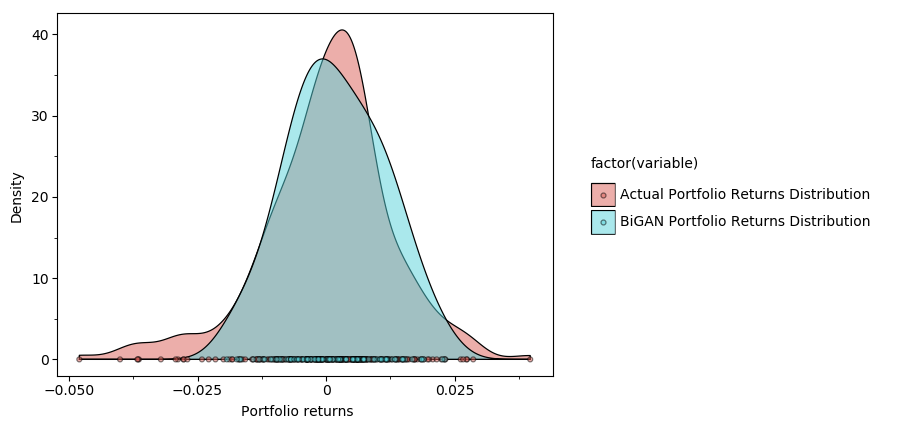

<ggplot: (-9223372036469612344)>


In [45]:
n_sim = 1000
noise = np.random.uniform(low=-1.0, high=1.0, size=(n_sim, z_size))
x = np.zeros((n_sim, 5))
x_mean = np.zeros(n_sim)

for i, xi in enumerate(noise):
    x[i, :] = (bigan.generator.predict(x=np.array([xi]))[0] * std) + mean
    x_mean[i] = np.average(a=x[i, :])

act_mean = np.zeros(ret_data.shape[0])
for i in range(ret_data.shape[0]):
    act_mean[i] = np.average(a=(ret_data.iloc[i] * std) + mean)
    
plot = ggplot(pd.melt(pd.concat([pd.DataFrame(x_mean, columns=["BiGAN Portfolio Returns Distribution"]).reset_index(drop=True),
                                 pd.DataFrame(act_mean, columns=["Actual Portfolio Returns Distribution"]).reset_index(drop=True)],
                                axis=1))) + \
geom_density(aes(x="value",
                 fill="factor(variable)"), 
             alpha=0.5,
             color="black") + \
geom_point(aes(x="value",
               y=0,
               fill="factor(variable)"), 
           alpha=0.5, 
           color="black") + \
xlab("Portfolio returns") + \
ylab("Density") + \
theme_matplotlib()
print(plot)

In [46]:
np.percentile(a=x_mean, axis=0, q=1)

-0.017367979896693916

## References

1. Goodfellow, I., Bengio, Y. and Courville A. (2016). Deep Learning (MIT Press).
2. Geron, A. (2017). Hands-On Machine Learning with Scikit-Learn & Tensorflow (O'Reilly).
3. Kingma, D. P., and Welling M. (2014). Auto-Encoding Variational Bayes (https://arxiv.org/abs/1312.6114).
4. http://scikit-learn.org/stable/#
5. https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
6. https://stackoverflow.com/questions/42177658/how-to-switch-backend-with-keras-from-tensorflow-to-theano
7. https://blog.keras.io/building-autoencoders-in-keras.html
8. https://keras.io
9. Chollet, F. (2018). Deep Learning with Python (Manning).
10. Hull, John C. (2010). Risk Management and Financial Institutions (Pearson).
11. https://towardsdatascience.com/automatic-feature-engineering-using-deep-learning-and-bayesian-inference-application-to-computer-7b2bb8dc7351
12. https://towardsdatascience.com/automatic-feature-engineering-using-generative-adversarial-networks-8e24b3c16bf3
13. Donahue, J., Krähenbühl, P. and Darrell, T. (2017). Adversarial Feature Learning (https://arxiv.org/pdf/1605.09782).
14. https://github.com/eriklindernoren/Keras-GAN